#0. Data Loading

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"topdancingindia","key":"c304be1874506d882773aeb27cc15ed3"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.18G/5.20G [00:31<00:00, 272MB/s]
100% 5.20G/5.20G [00:31<00:00, 176MB/s]


In [6]:
#extract contents to data_raw
from zipfile import ZipFile
import shutil

with ZipFile("skin-cancer-mnist-ham10000.zip", 'r') as zObject:
	zObject.extractall(path="data_raw/")

shutil.move("data_raw/HAM10000_metadata.csv", "/content", copy_function = shutil.copytree)

'/content/HAM10000_metadata.csv'

In [7]:
import pandas as pd

df = pd.read_csv("HAM10000_metadata.csv")
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [8]:
# mapping dx to corresponding skin lesions
skin_lesions_dict = {
    'akiec': 'Actinic Keratosis',
    'bcc': 'Basal Cell Carcinoma',
    'bkl': 'Benign Keratosis',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic Nevi',
    'vasc': 'Vascular Lesions' }

The HAM10000 dataset is a collection of 10015 images of pigmented skin lesions, categorized into seven subgroups: <br>Data Description: https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf
<br><br>
- Actinic Keratosis [AKIEC]: Non-invasive type of squamous cell carcinoma that can be treated locally without surgery.<br><br>
- Basal Cell Carcinoma [BCC]: A type of epithelial skin cancer that rarely spreads, but if left untreated, it might become aggressive and relapse.<br><br>
- Benign Keratosis [BKL]: It is a generic class that includes seborrheic keratoses, lichen-planus-like keratoses, and solar lentigo. The three subgroups may look different dermatoscopically, but they are grouped as they are similar biologically and often reported under the same generic term histopathologically.<br><br>
- Dermatofibroma [DF]: This skin lesion is either benign growth or an inflammatory response to minor trauma.<br><br>
- Melanoma [MEL]: Melanoma is a cancerous tumor that develops from melanocytes and can take many forms. It can be treated with a primary surgical procedure if caught early enough.<br><br>
- Melanocytic Nevi [NV]: Skin lesions are benign neoplasms of melanocytes and appear in various shapes and sizes. From a dermatoscopic standpoint, the variants may differ dramatically.<br><br>
- Vascular Lesions [VASC]: Cherry antifoams, angiokeratomas, and pyogenic granulomas are examples of benign or malignant angiomas.

# 1. Data Preprocessing

In [9]:
# merging images from both folders HAM10000_images_part1 and HAM10000_images_part2 into one directory
shutil.copytree("data_raw/HAM10000_images_part_1", "data_raw/HAM10000_images_part_2", dirs_exist_ok=True)
shutil.move("data_raw/HAM10000_images_part_2", "data_skin", copy_function = shutil.copytree)

'data_skin'

In [10]:
# checking number of images in merged directory
import os

dir_path = "data_skin"
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

10015


In [11]:
# deleting data_raw
shutil.rmtree("data_raw")

In [12]:
df['lesion_type'] = df['dx'].map(skin_lesions_dict.get)
df['lesion_type_idx'] = pd.Categorical(df['lesion_type']).codes
df['path'] = "data_skin/" + df['image_id'] + '.jpg'

In [13]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        lesion_type  lesion_type_idx                        path  
0  Benign Keratosis                2  data_skin/ISIC_0027419.jpg  
1  Benign Keratosis                2  data_skin/ISIC_0025030.jpg  
2  Benign Keratosis                2  data_skin/ISIC_0026769.jpg  
3  Benign Keratosis                2  data_skin/ISIC_0025661.jpg  
4  Benign Keratosis                2  data_skin/ISIC_0031633.jpg

In [14]:
# check size of image
import cv2

cv2.imread(df['path'][0]).shape

(450, 600, 3)

In [15]:
# resize to (240,240,3)
from PIL import Image
import numpy as np

def resize_image(image_path, size=(240, 240)):
    image = Image.open(image_path)
    resized_image = image.resize(size)
    return np.array(resized_image)

df['image'] = df['path'].apply(resize_image)

df['image'][0].shape

(240, 240, 3)

In [16]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        lesion_type  lesion_type_idx                        path  \
0  Benign Keratosis                2  data_skin/ISIC_0027419.jpg   
1  Benign Keratosis                2  data_skin/ISIC_0025030.jpg   
2  Benign Keratosis                2  data_skin/ISIC_0026769.jpg   
3  Benign Keratosis                2  data_skin/ISIC_0025661.jpg   
4  Benign Keratosis                2  data_skin/ISIC_0031633.jpg   

                                               image  
0  [[[187, 149, 192], [189, 152, 195], [191, 155,...  
1  [[[24, 14, 22], [25, 14, 23], [25, 14, 23], [2...  
2  [[[186, 127, 136], [188, 128, 137], [191, 134,...  
3  [[[23, 11, 15], [24, 11, 18], [24, 11, 19], [2...  
4  [[[124, 83, 105], [131, 88, 111], [137, 93, 11...

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lesion_id        10015 non-null  object 
 1   image_id         10015 non-null  object 
 2   dx               10015 non-null  object 
 3   dx_type          10015 non-null  object 
 4   age              9958 non-null   float64
 5   sex              10015 non-null  object 
 6   localization     10015 non-null  object 
 7   lesion_type      10015 non-null  object 
 8   lesion_type_idx  10015 non-null  int8   
 9   path             10015 non-null  object 
 10  image            10015 non-null  object 
dtypes: float64(1), int8(1), object(9)
memory usage: 792.3+ KB


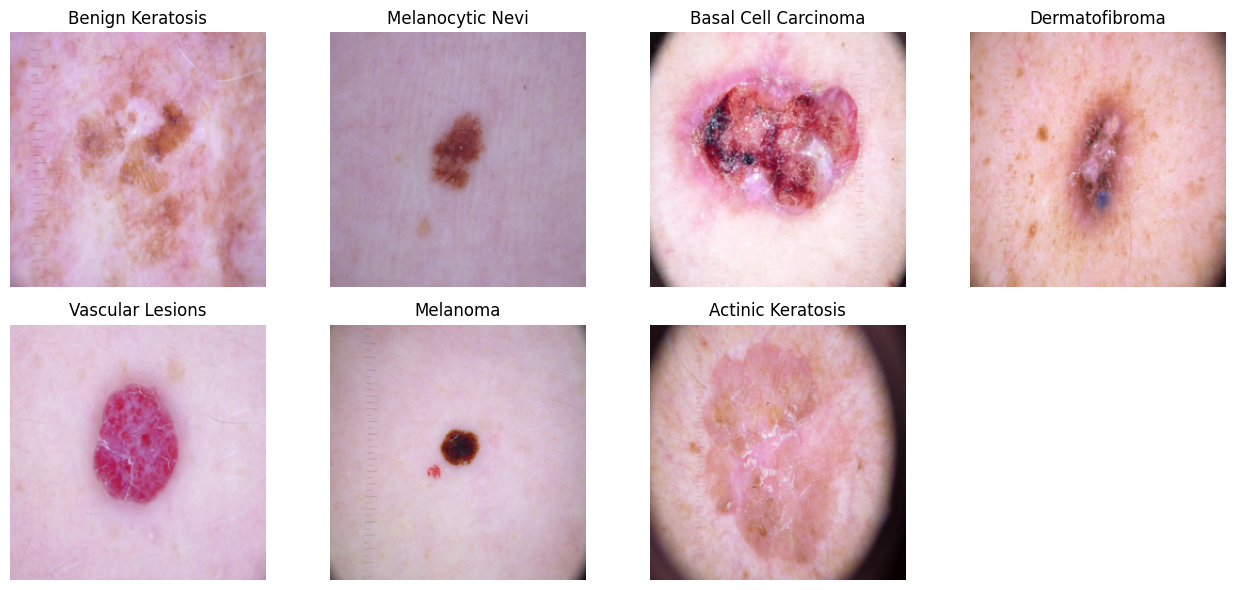

In [18]:
# plotting images
import matplotlib.pyplot as plt
import seaborn as sns

df_sampled = df.drop_duplicates('lesion_type').sample(7, random_state=42)
df_sampled.reset_index(drop=True, inplace=True)

fig = plt.figure(figsize=(13, 6))

for i, (_, row) in enumerate(df_sampled.iterrows(), 1):
    ax = fig.add_subplot(2, 4, i)
    ax.imshow(row['image'])
    ax.set_title(row['lesion_type'])
    ax.axis('off')

plt.tight_layout()
plt.savefig('samples.png', dpi=300)
plt.show()

# 2. Data Exploration

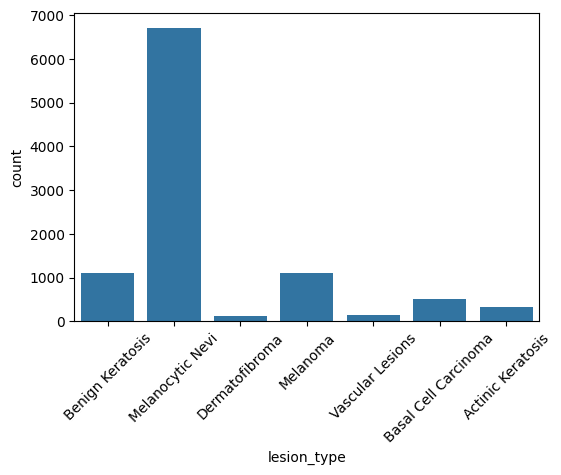

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.countplot(x='lesion_type', data=df, ax=ax)
plt.xticks(rotation=45)
plt.show()

Melanocytic Nevi is the most common lesion type in this dataset with over 6500 instances.

Model trained on this dataset may perform poorly in predicting the less represented classes due to the small number of examples to learn from. This limitation should be considered when interpreting results derived from the model.

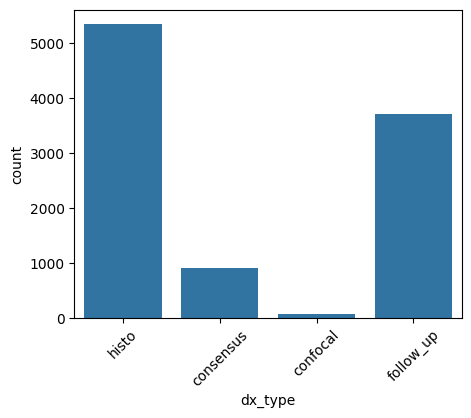

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.countplot(x='dx_type', data=df, ax=ax)
plt.xticks(rotation=45)
plt.show()

Histology image analysis is the most common method of skin cancer diagnoses.

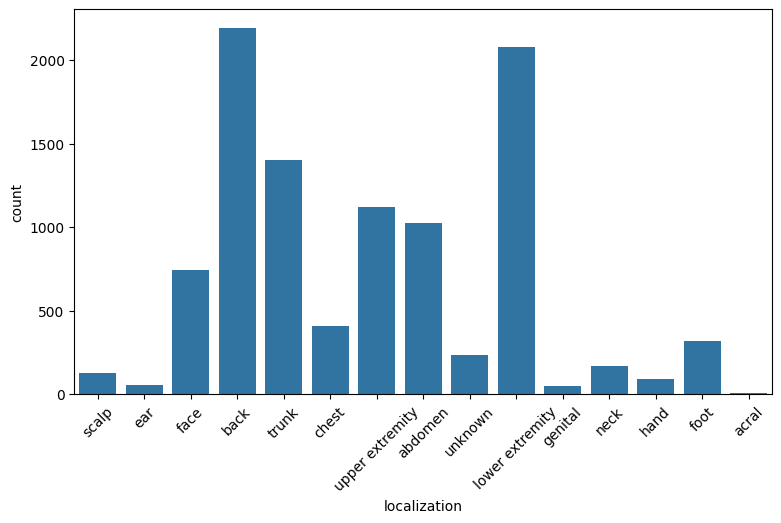

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9,5))
sns.countplot(x='localization', data=df, ax=ax)
plt.xticks(rotation=45)
plt.show()

Skin cancer is most prevalent in back and lower extremeties.

# 3. Model Building

In [19]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Activation, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

In [20]:
BATCH_SIZE = 16
IMAGE_SIZE = 240
CHANNELS = 3
EPOCHS = 40

In [21]:
# divide dataset into train and test 80:20
features = df['image']
target = df['lesion_type_idx']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 42)

# divide train dataset into train and validation 90:10
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

In [22]:
# converting image array to tensorFlow tensor
x_train = tf.stack([tf.convert_to_tensor(image) for image in x_train])
y_train = tf.stack([tf.convert_to_tensor(image) for image in y_train])
x_test = tf.stack([tf.convert_to_tensor(image) for image in x_test])
y_test = tf.stack([tf.convert_to_tensor(image) for image in y_test])
x_validate = tf.stack([tf.convert_to_tensor(image) for image in x_validate])
y_validate = tf.stack([tf.convert_to_tensor(image) for image in y_validate])

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
validate_data = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))

In [23]:
# defining data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomWidth(factor=(-0.2, 0.2)),
  layers.experimental.preprocessing.RandomHeight(factor=(-0.2, 0.2)),
])

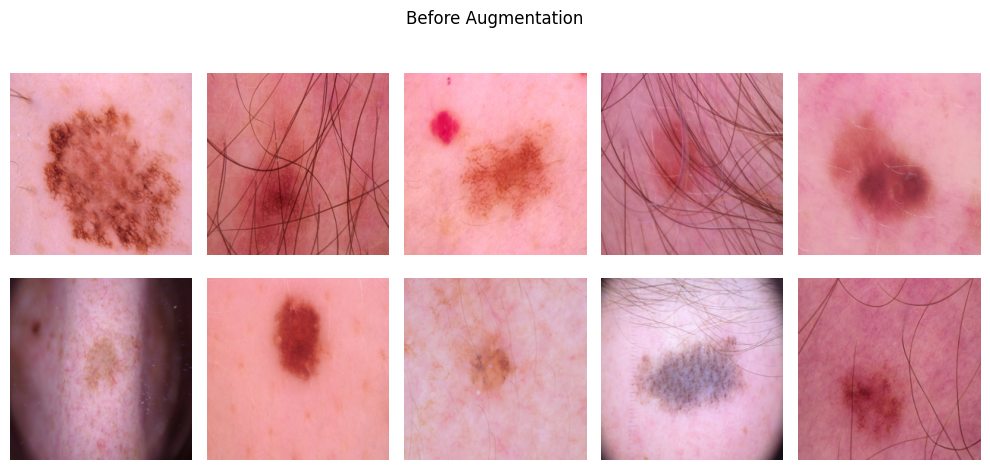

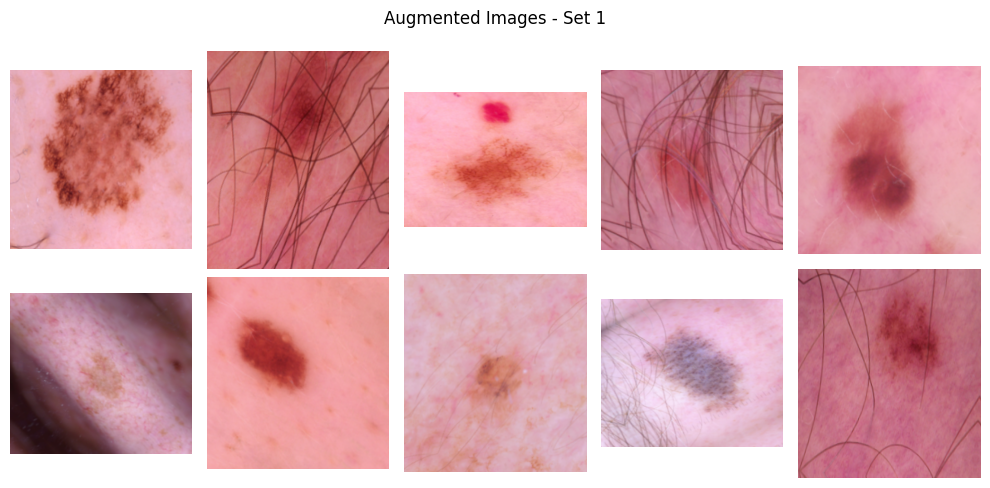

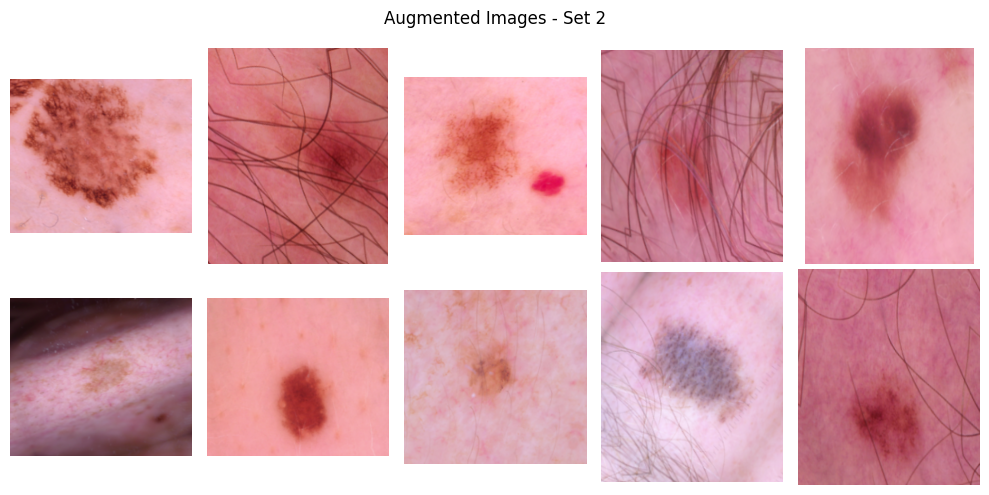

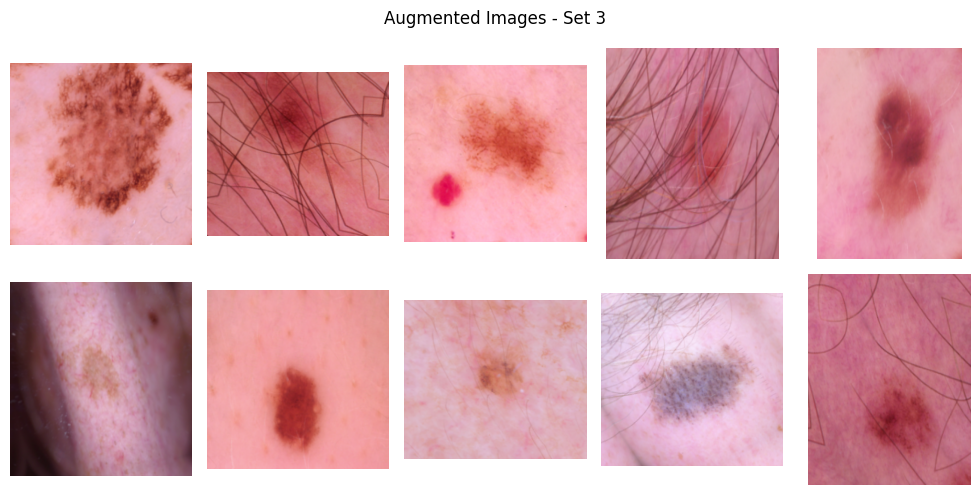

In [24]:
# plot original images
plt.figure(figsize=(10, 5))

for i, (image, label) in enumerate(train_data.take(10)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis("off")

plt.suptitle("Before Augmentation")
plt.tight_layout()
plt.show()

# plot augmented images
sampled_train_data = train_data.take(10)

augmented_images = []
for image, label in sampled_train_data:
    image = tf.cast(image, tf.uint8)
    augmented_batch = []
    for _ in range(3):
        augmented_image = data_augmentation(tf.expand_dims(image, 0), training=True)
        augmented_batch.append(augmented_image[0])
    augmented_images.append(augmented_batch)

for j in range(3):
    plt.figure(figsize=(10, 5))
    for i, augmented_image in enumerate(augmented_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(augmented_image[j].numpy().astype("uint8"))
        plt.axis("off")
    plt.suptitle(f"Augmented Images - Set {j+1}")
    plt.tight_layout()
    plt.show()

In [25]:
# shuffle and batch the dataset and prefetch data for better performance
train_data = train_data.shuffle(buffer_size=1000).batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.shuffle(buffer_size=1000).batch(BATCH_SIZE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

validate_data = validate_data.shuffle(buffer_size=1000).batch(BATCH_SIZE)
validate_data = validate_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
# apply data augmentation on training data
train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [27]:
x_train.shape

TensorShape([7210, 240, 240, 3])

In [28]:
for x, y in train_data.take(1):
    print("Input shape:", x.shape)
    print("Output shape:", y.shape)

Input shape: (16, 277, 236, 3)
Output shape: (16,)


Architecture of CNN:<br>

- The input layer should match the dimensions of input images (240, 240, 3).<br>

- The number of neurons in the output layer should match the number of classes for classification (7).

In [29]:
# resizing images to (240,240)
# rescaling the pixel values from [0, 255] to [0, 1]
resize_rescale_layer = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(240,240),
  layers.experimental.preprocessing.Rescaling(1./224),
])

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_rescale_layer,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', padding = 'same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (16, 240, 240, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 240, 240, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (16, 120, 120, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 120, 120, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 60, 60, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [32]:
model.input_shape

(16, 240, 240, 3)

In [33]:
model.output_shape

(16, 7)

In [34]:
# adjusting the learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [35]:
# add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [36]:
# define the optimizer
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    name="Adam"
)

In [37]:
# compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [69]:
shutil.rmtree("checkpoints")

In [38]:
# defining the callbacks
import pickle

# specifying where we are saving our models
checkpoint_dir = "checkpoints/"
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)

# custom callback to save history and model checkpoints
class ModelAndHistoryCheckpoint(ModelCheckpoint):
    def __init__(self, *args, history_path=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.history_path = history_path
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        # Save history after each epoch
        self.history[epoch] = logs
        with open(self.history_path, 'wb') as f:
            pickle.dump(self.history, f)

# save the best model and history after each epoch
checkpoint_callback = ModelAndHistoryCheckpoint(
    os.path.join(checkpoint_dir, "model_epoch_best.h5"),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
    mode='min',
    save_freq='epoch',
    history_path=os.path.join(checkpoint_dir, "history.pkl")
)

In [39]:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, early stopping)
history = model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=validate_data, callbacks=[checkpoint_callback, reduce_lr, early_stopping], verbose=1)

Epoch 1/40
451/451 [==============================] - ETA: 0s - loss: 1.0210 - accuracy: 0.6696
Epoch 1: val_loss improved from inf to 1.00243, saving model to checkpoints/model_epoch_best.h5
451/451 [==============================] - 60s 119ms/step - loss: 1.0210 - accuracy: 0.6696 - val_loss: 1.0024 - val_accuracy: 0.6633 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/40
450/451 [============================>.] - ETA: 0s - loss: 0.9341 - accuracy: 0.6762
Epoch 2: val_loss improved from 1.00243 to 0.90326, saving model to checkpoints/model_epoch_best.h5
451/451 [==============================] - 52s 116ms/step - loss: 0.9341 - accuracy: 0.6764 - val_loss: 0.9033 - val_accuracy: 0.6858 - lr: 0.0010
Epoch 3/40
450/451 [============================>.] - ETA: 0s - loss: 0.8813 - accuracy: 0.6889
Epoch 3: val_loss improved from 0.90326 to 0.87296, saving model to checkpoints/model_epoch_best.h5
451/451 [==============================] - 52s 116ms/step - loss: 0.8807 - accuracy: 0.6890 - val_loss: 0.8730 - val_accuracy: 0.6883 - lr: 0.0010
Epoch 4/40
450/451 [============================>.] - ETA: 0s - loss: 0.8465 - accuracy: 0.6972
Epoch 4: val_loss improved from 0.87296 to 0.81694, saving model to checkpoints/model_epoch_best.h5
451/451 [==============================] - 51s 113ms/step - loss: 0.8469 - accuracy: 0.6972 - val_loss: 0.8169 - val_a

In [40]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
val_loss, val_acc = model.evaluate(x_validate, y_validate, verbose=1)

26/26 [==============================] - 0s 13ms/step - loss: 0.6296 - accuracy: 0.7606


In [41]:
print("Validation")
print("loss :", val_loss, "- accuracy :", val_acc)
print("\nTest")
print("loss :", test_loss, "- accuracy :", test_acc)

Validation
loss : 0.6296004056930542 - accuracy : 0.7605984807014465

Test
loss : 0.6504276990890503 - accuracy : 0.7638542056083679


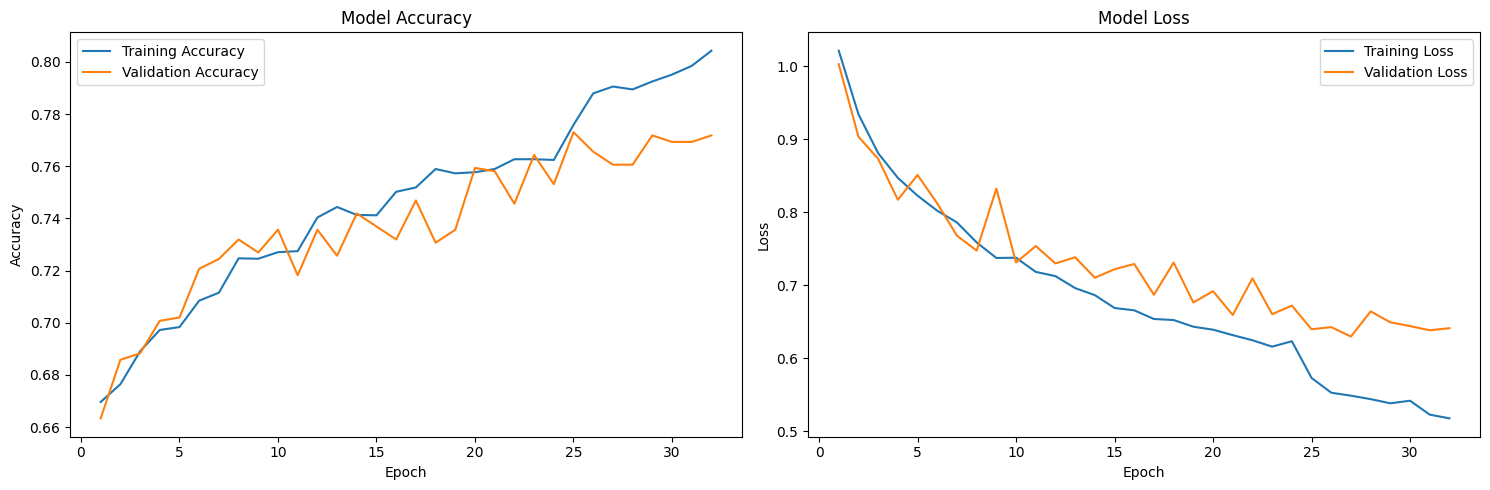

In [42]:
def plot_model_metrics(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    epochs_range = range(1, len(model_history.history['accuracy']) + 1)
    training_accuracy = model_history.history['accuracy']
    validation_accuracy = model_history.history['val_accuracy']
    training_loss = model_history.history['loss']
    validation_loss = model_history.history['val_loss']

    # plot training and validation accuracy
    axs[0].plot(epochs_range, training_accuracy, label='Training Accuracy')
    axs[0].plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # plot training and validation loss
    axs[1].plot(epochs_range, training_loss, label='Training Loss')
    axs[1].plot(epochs_range, validation_loss, label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_model_metrics(history)

The training accuracy starts at approximately 68% and steadily increases to just over 80% by the 30th epoch.
The validation accuracy begins at the same point but follows a more volatile path, reaching around 78% by the 30th epoch.
There is a noticeable gap of about 2-3 percentage points between training and validation accuracy towards the end of the training, which may be an indication of overfitting.

The training loss starts near 1.0 and consistently decreases to about 0.5 by the 30th epoch.
The validation loss also starts near 1.0 but has more fluctuation, decreasing to around 0.6, with spikes that go up as high as approximately 0.9.
The difference in loss between the training and validation suggests that the model may be fitting the training data closely but struggling to generalize on the validation set.

This suggests the model might benefit from further regularization or a review of the validation dataset. Potential improvements might include techniques to reduce overfitting, such as different dropout rates, more data, or data augmentation.

Actual label: Vascular Lesions
1/1 [==============================] - 0s 119ms/step
Predicted label: Vascular Lesions


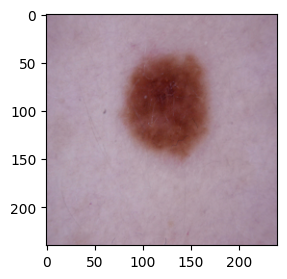

In [45]:
# classifying a sample image
class_names = df['lesion_type'].unique().tolist()

for images, labels in test_data.take(1):
    sample_image = images[0].numpy().astype('uint8')
    actual_label = labels[0].numpy()
    plt.figure(figsize=(3, 3))
    plt.imshow(sample_image)
    print("Actual label:",class_names[actual_label])
    prediction = model.predict(images)
    print("Predicted label:",class_names[np.argmax(prediction[0])])

In [46]:
# inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_batch = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    prediction_confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class_name, prediction_confidence

1/1 [==============================] - 0s 19ms/step


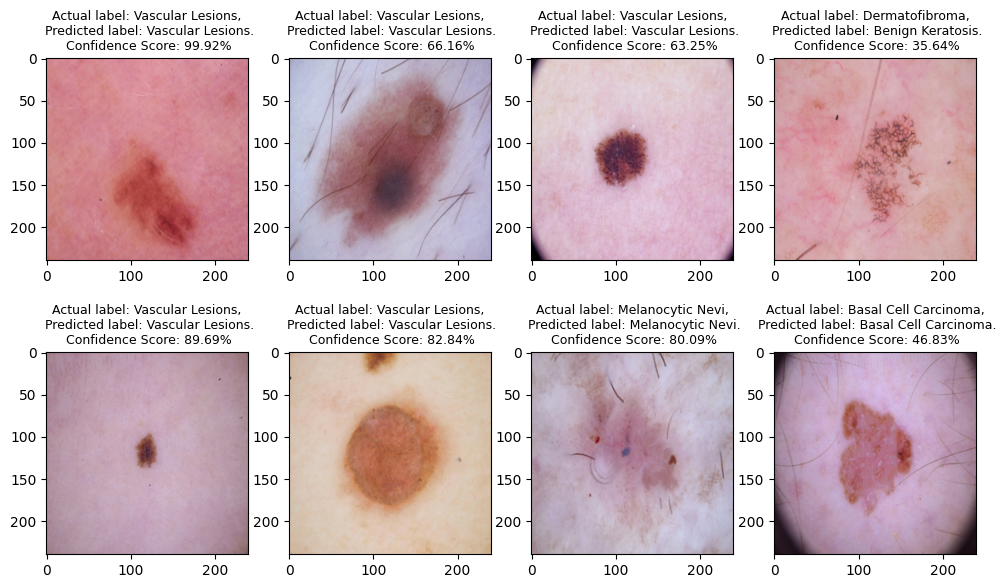

In [61]:
# evaluating the model on sample images
plt.figure(figsize=(12, 7))
for images, labels in test_data.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class_name, prediction_confidence = predict(model, images[i].numpy())
        actual_class_label = class_names[labels[i]]
        plt.title(f"Actual label: {actual_class_label},\n Predicted label: {predicted_class_name}.\n Confidence Score: {prediction_confidence}%", fontsize=9)

In [56]:
# saving the model
model.save('model_final')